# 1. Importing Libraries

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb 
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


import warnings

# Configurations

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

# 2. Loading Data

In [4]:
df = pd.read_csv('diabetes.csv')

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.shape

(768, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(0)

# 3. Exploratory Data Analysis

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [11]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

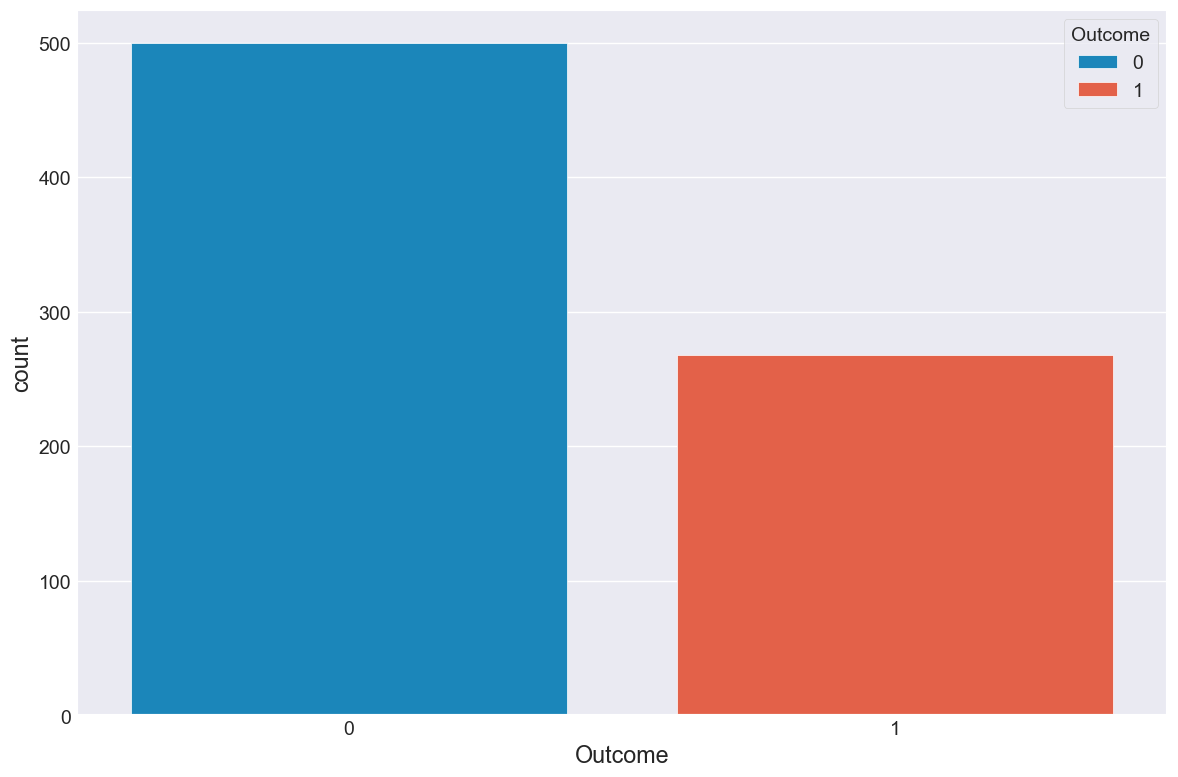

In [12]:
sns.countplot(x=df['Outcome'], hue=df['Outcome'])
plt.tight_layout()

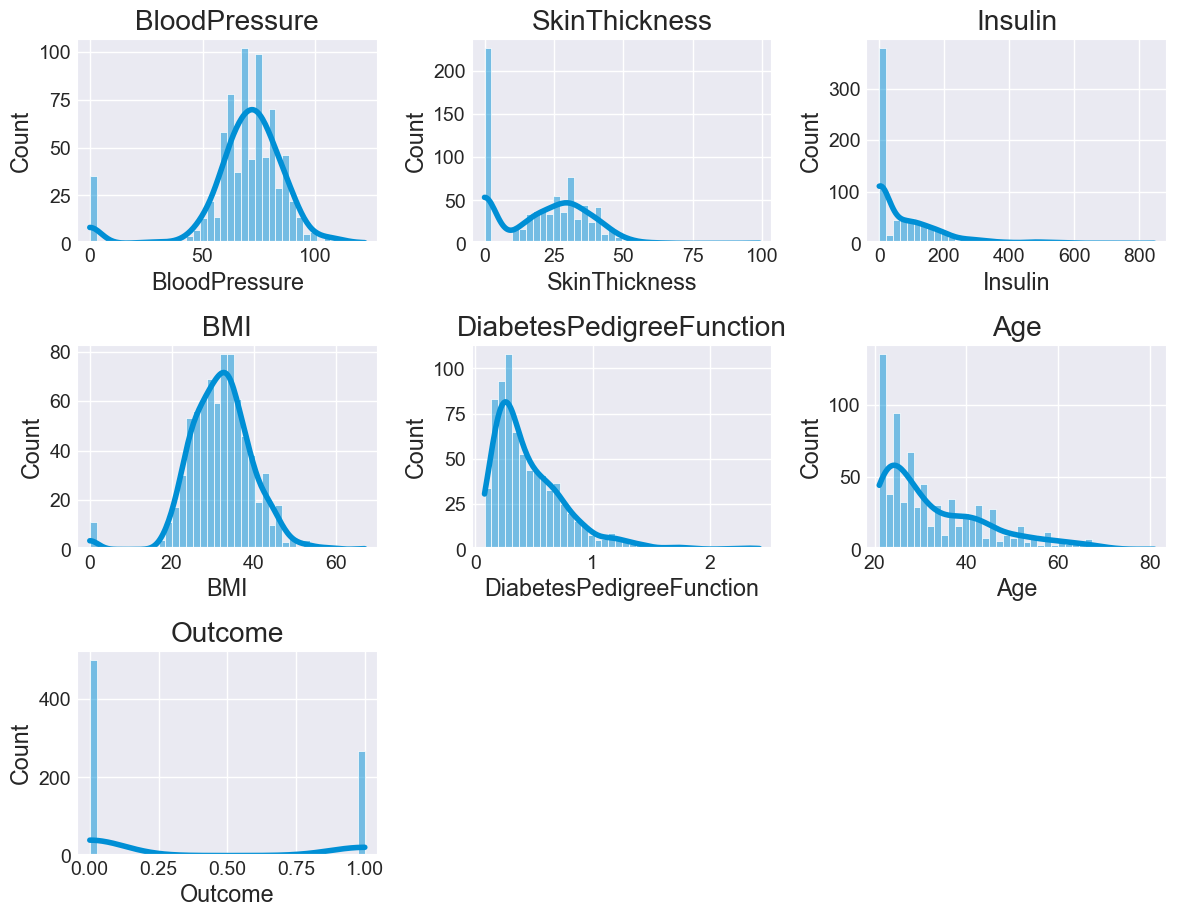

In [13]:
plt.figure(figsize=(12, 15))
for i, c in enumerate(df.columns[2:]):
    plt.subplot(5, 3, i+1)
    sns.histplot(df[c], bins=40, kde=True)
    plt.title(c)
plt.tight_layout()

In [14]:
columns_to_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in columns_to_check:
    zero_count = (df[col] == 0).sum()
    zero_percentage = 100 * zero_count /len(df)
    print(f"{col}: {zero_count} %{zero_percentage:.2f}")

Glucose: 5 %0.65
BloodPressure: 35 %4.56
SkinThickness: 227 %29.56
Insulin: 374 %48.70
BMI: 11 %1.43


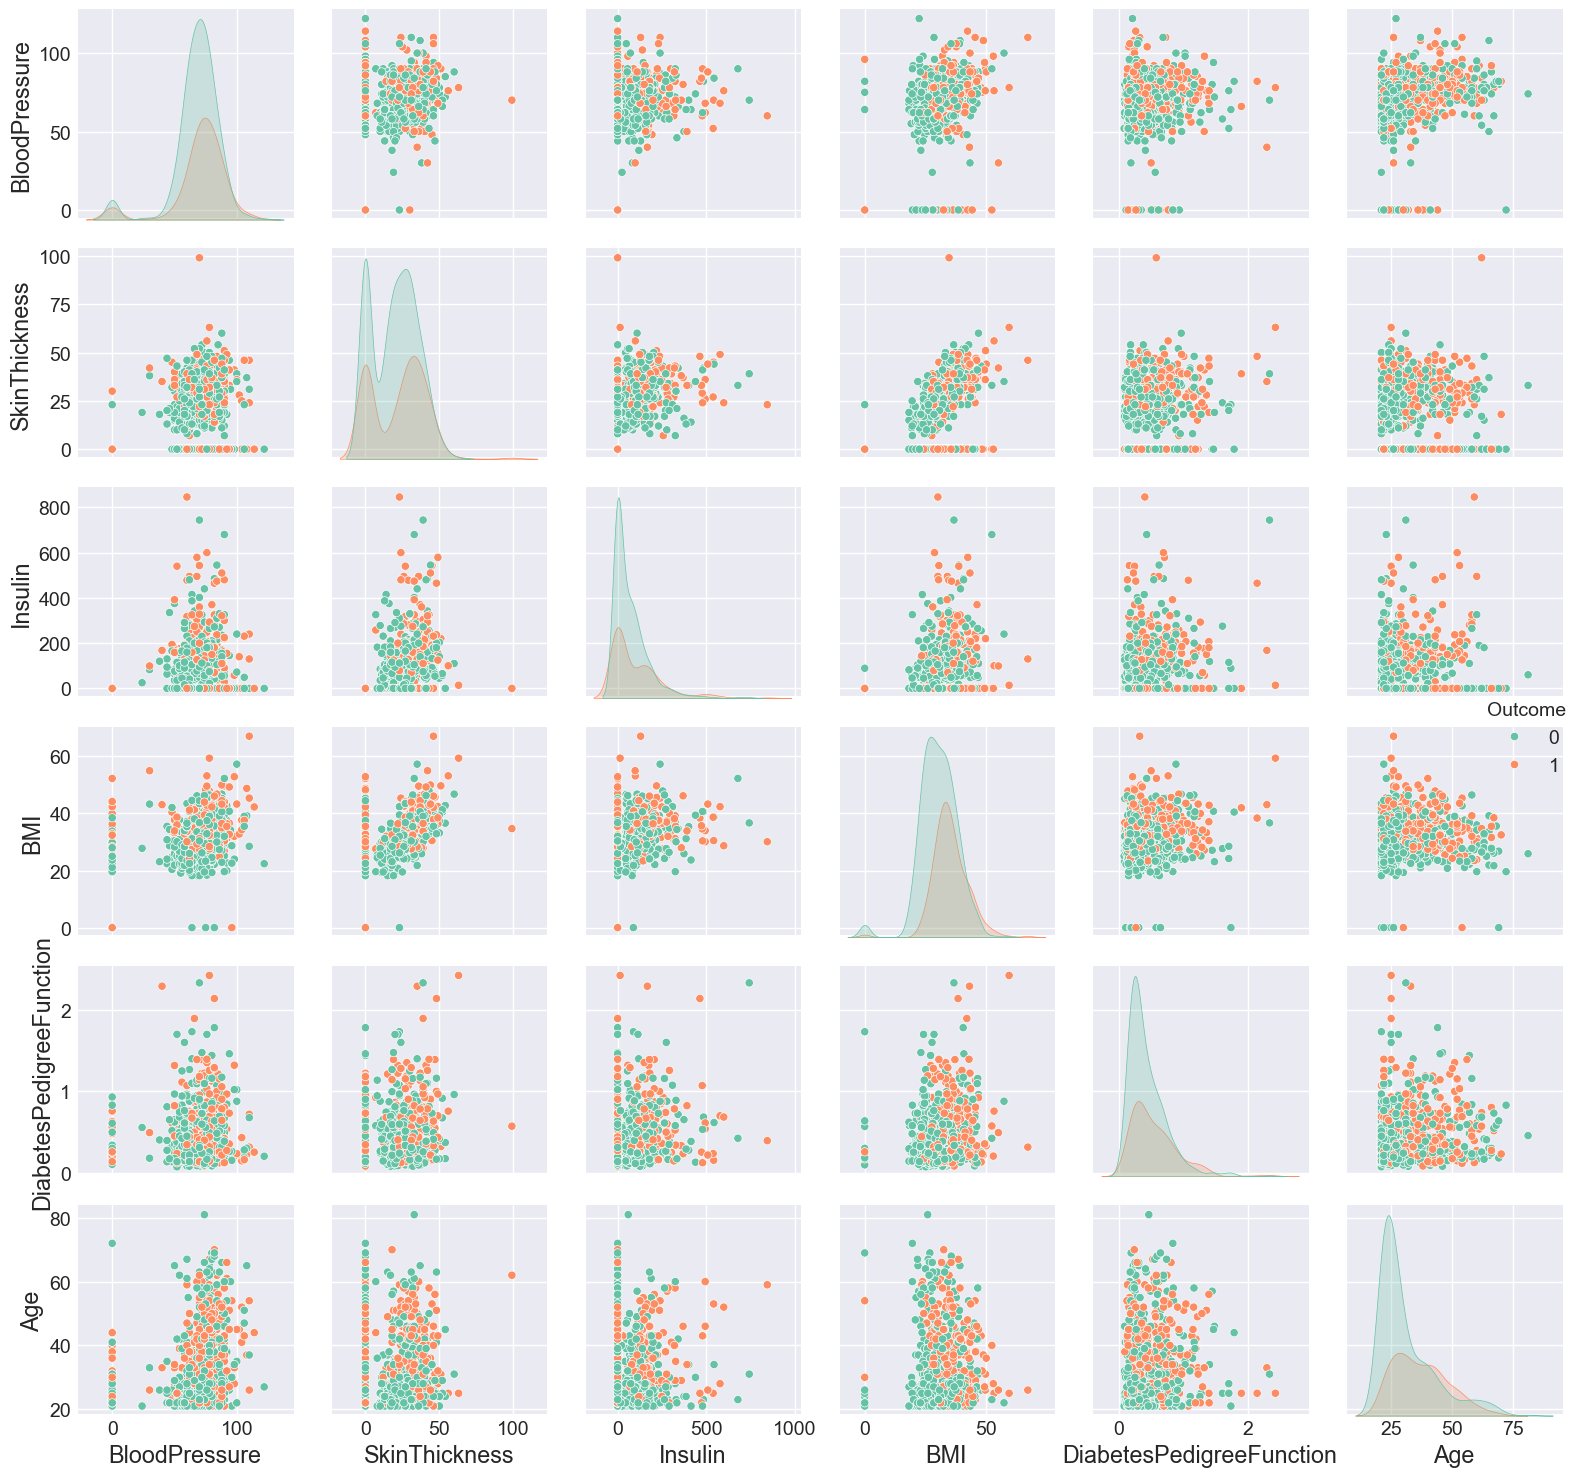

In [15]:
sns.pairplot(df[['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']], hue='Outcome', palette='Set2')
plt.tight_layout()

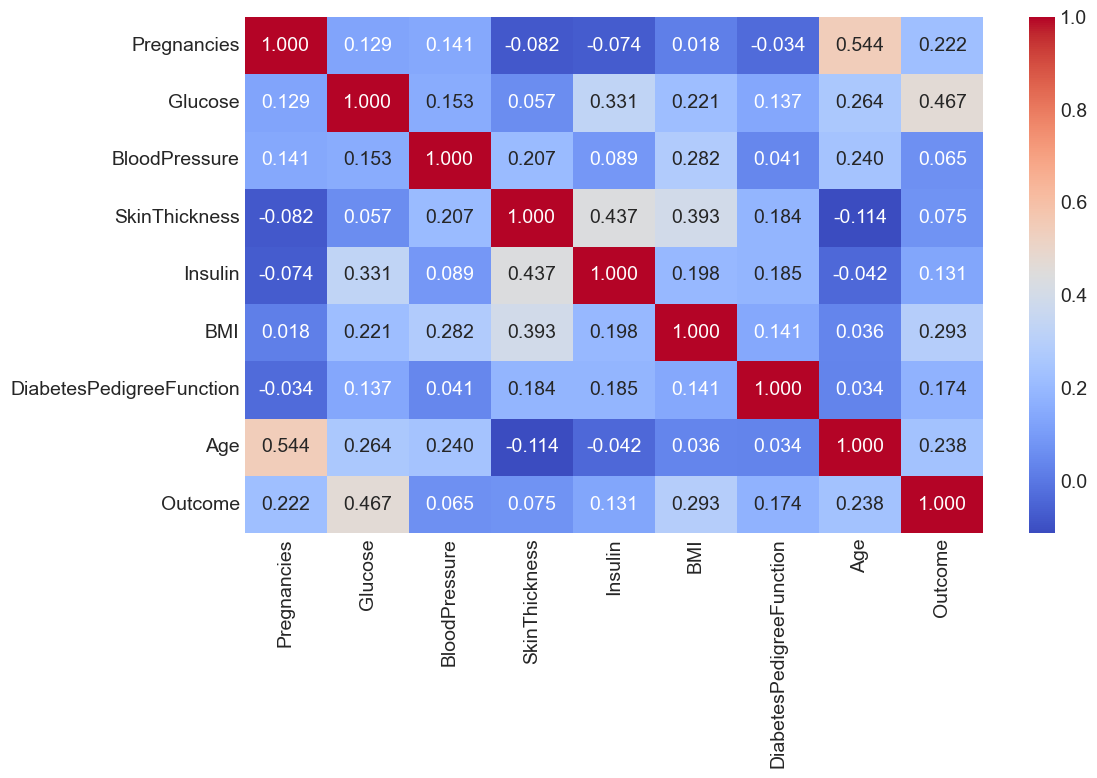

In [16]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.3f')
plt.tight_layout()

In [17]:
df.corr(numeric_only=True)['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

# 4. Data Preprocessing

In [18]:
columns_to_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0 değerlerini NaN yap
df[columns_to_check] = df[columns_to_check].replace(0, np.nan)

# NaN'leri median ile doldur
df[columns_to_check] = df[columns_to_check].fillna(df[columns_to_check].median())


In [19]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [20]:
# Downsampling the dataset to balance the classes
df_majority = df[df['Outcome'] == 0]
df_minority = df[df['Outcome'] == 1]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.shape

(536, 9)

In [21]:
df = df_downsampled

In [22]:
df['Outcome'].value_counts()

Outcome
0    268
1    268
Name: count, dtype: int64

In [23]:
X = df.drop(columns=['Outcome'])
y = df[['Outcome']]

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. Model Training

In [26]:
models = {
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'SVC': SVC(),
    'XGBClassifier': xgb.XGBClassifier(),
    'LightGBMClassifier': lgb.LGBMClassifier(verbose=-1)
}

def evaluate(X_train, y_train, X_test, y_test):
    results = []

    for i, (model_name, model) in enumerate(tqdm(models.items())):
        if 'random_state' in model.get_params():
            model.set_params(random_state=42)

        print(f'Training {model_name}...')
        y_pred = model.fit(X_train, y_train).predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        

        plt.subplot(3, 5, i+1)
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(model_name, fontsize=12)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
        
    plt.suptitle('Confusion Matrices of All Models')
    plt.tight_layout()
    
    report = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

  0%|          | 0/12 [00:00<?, ?it/s]

Training GaussianNB...
Training BernoulliNB...
Training LogisticRegression...
Training ExtraTreesClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...
Training GradientBoostingClassifier...
Training AdaBoostClassifier...
Training KNeighborsClassifier...
Training SVC...
Training XGBClassifier...
Training LightGBMClassifier...


,Model,Accuracy,Precision,Recall,F1 Score
0,SVC,0.833333,0.836945,0.838810,0.833276
1,ExtraTreesClassifier,0.814815,0.813209,0.814943,0.813793
2,KNeighborsClassifier,0.805556,0.810690,0.811657,0.805539
3,LogisticRegression,0.787037,0.786466,0.782601,0.783906
4,RandomForestClassifier,0.787037,0.785172,0.786060,0.785548
5,GradientBoostingClassifier,0.768519,0.767170,0.769111,0.767542
6,XGBClassifier,0.759259,0.757177,0.757177,0.757177
7,AdaBoostClassifier,0.759259,0.758730,0.753718,0.755145
8,LightGBMClassifier,0.759259,0.757586,0.755448,0.756250
9,BernoulliNB,0.722222,0.720330,0.721550,0.720690


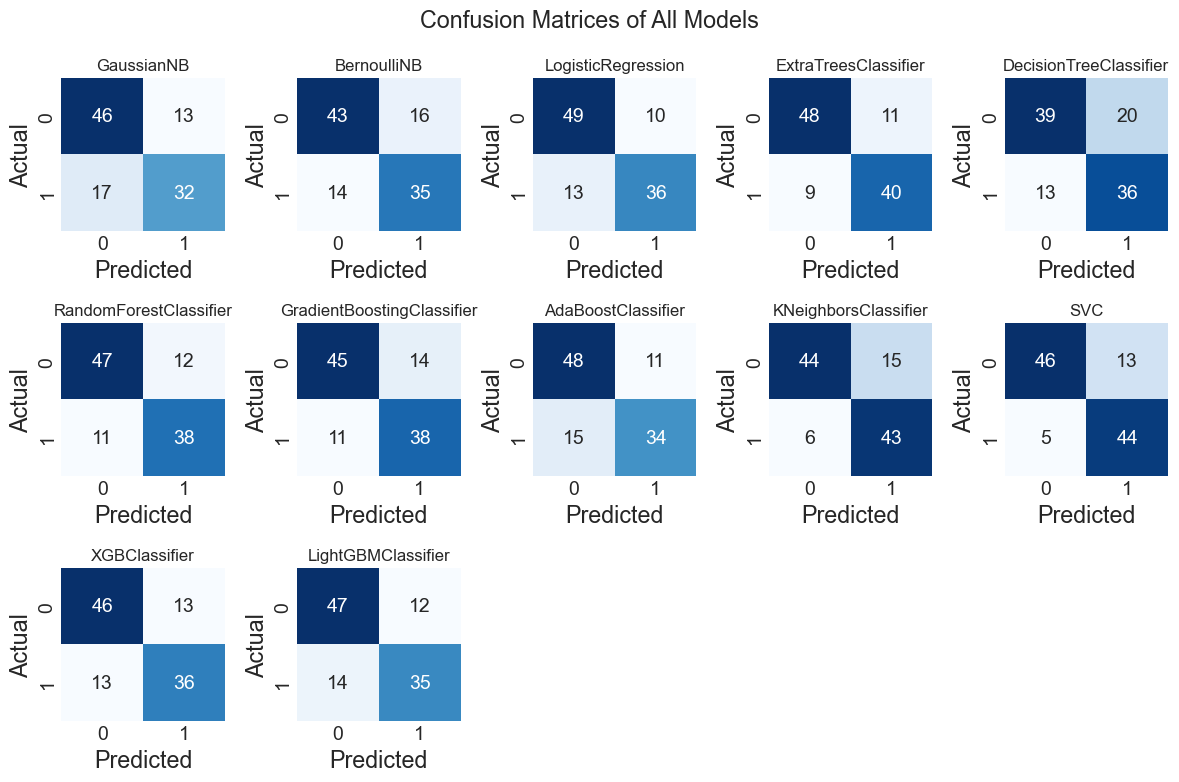

In [27]:
evaluate(X_train, y_train, X_test, y_test)

# 6. Build Pipeline with the best model, Save the model

In [32]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(random_state=42))
])
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('model', SVC(random_state=42))])

In [33]:
y_pred = pipeline.predict(X)

In [36]:
joblib.dump(pipeline, 'diabetes_predict.pkl')

['diyabet_tahmin.pkl']

test_df = pd.read_csv('test.csv', index_col='id')
predictions = pipeline.predict(test_df)
submission = pd.DataFrame({
    'id': test_df.index,
    'Machine failure': predictions
})
submission.head()

# 7. Conclusion

We built a pipeline to predict diabets using a SVC. We saved the pipeline.